## Q2 : Add control variate (first order polynomial) to implement Zero variance Markov chain Monte Carlo Method (ZV-MCMC)

With the simple MCMC method, the estimator was determined by approximating the expectation of $g(x)$, a density function going from R3 to R, giving the density of the 3 paramters knowing the data, based the normal distribution (not standardized). To estimate this expectation we averaged the combinations of M iteration of the 3 parameters simulated by the simple MCMC algorithm. We then get an estimate of $μ_g$. The Zero variance Markov chain Monte Carlo method consists in reducing the MCMC error by replacing $g$ with a different function, $f$, obtained by properly re-normalizing $g$. The function $f$ is constructed so that its expectation, equals $μ_f$ , but its variance is much smaller.

ZV-MCMC Procedure:

* First step : run a short MCMC simulation to estimate the parameters of the trial function
    
* Second step : run a long simulation with the re-normalized posterior function to estimate the posterior mean of each parameter with less variance

### Libraries set up

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import os
from scipy.optimize import minimize
import statistics

In [2]:
os.chdir("/Users/ludovic/Desktop/ENSAE/S2/MC/Garch_ZV_MCMC") #set up the location of the project 

### Simulation of data following a GARCH(1,1) process

We take the ssimulated garch process of question 1 (with parameters 0.3, 0.2, 0.5): 

In [3]:
r_garch = pd.read_csv("r_garch.csv")
r_garch = np.array(r_garch["0"])

### 1er MCMC

We do not re-explain the 1st step, it is simply the same process as Q1 but we can afford to run few iterations because this step is simply used to estimate the polynomial for the second step.

In [4]:
def g_i(r, h):
    return -0.5 * np.log(h) - 0.5 * (r**2 / h) # Normal law because r_{t}|F_t-1 follow N(0,h_t)

def g(x , data, h_initial):
    h = h_initial 
    LL = g_i(data[0],h) # density is initialized with our first simulated data

    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        LL += g_i(data[i],h)

    return LL

In [5]:
def optimize_h(data):
    fun = lambda h: -g_i(data[0], h) # function to minimize
    h_init = 1 # initial value for h
    result = minimize(fun, h_init, method='BFGS') # grandient descent method

    h_optimal = result.x[0] #result
    return h_optimal

optimize_h(r_garch)

1.4128118365161495

In [6]:
M = 2000 # size of the desired sample
#X = np.random.rand(3) # Random starting point for the Markov chain (dim=3)
X= [0.2, 0.15, 0.6] # Deterministic starting point for the Markov chain (dim=3)
sigma = 0.015  # volatility for the proposal function (fixed by looking for an acceptance rate between 0.3 and 0.6)
x1list = []  # for keeping track of omega values
x2list = [] # for keeping track of alpha values
x3list = [] # for keeping track of beta values
numaccept = 0 # counts the number of acceptance in the accept/rejct algorithm
i = 0 #initialization of i, the total number of iteration 
h_initial=optimize_h(r_garch) #initial h for the density computation

Algorythm :

In [7]:
while numaccept < M:
    Y = X + np.random.normal(loc=0, scale=sigma, size=3)  # Proposal move with a normal distribution (dim=3 because 3 parameters)
    U = np.log(np.random.rand(1)) # Random draw in a uniform distribution for accept/reject
    if np.all(Y > 0): # Reject all samples where any parameter is negative (truncated normal distribution)
        alpha = g(Y, data = r_garch, h_initial=h_initial) - g(X, data = r_garch, h_initial=h_initial)  # Difference between current and previous density accept/reject
        if U < alpha:  # Reject if the ratio of densities is lower than a draw in a uniform distribution
            X = Y  # Accept proposal
            numaccept += 1 # Counts the number of acceptance in the accept/reject algorithm
    
            x1list.append(X[0])   # Add the values to the lists of omega
            x2list.append(X[1])   # Add the values to the lists of alpha
            x3list.append(X[2])   # Add the values to the lists of beta
    
    # Output progress report (can be long)
    i += 1 # Counts the number of total iteration 
    if (i % 1000) == 0:
        print(" ...", i)

 ... 1000
 ... 2000
 ... 3000
 ... 4000
 ... 5000


#### Exploitation of the results

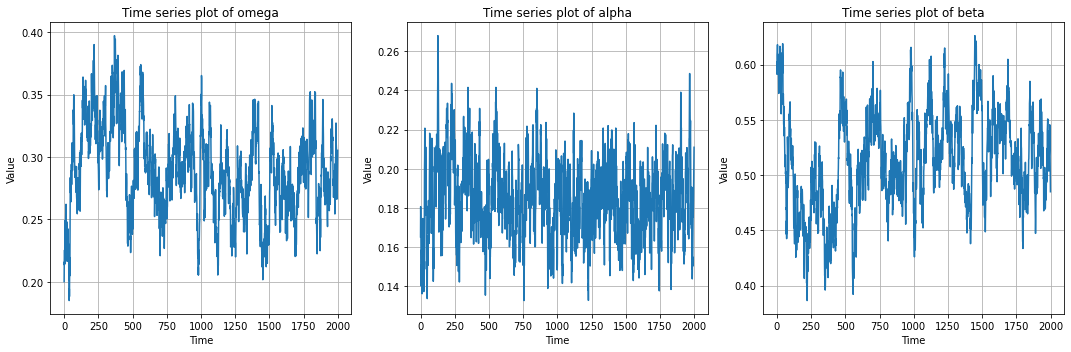

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot time series graphs for x1list, x2list and x3list
axs[0].plot(x1list)
axs[0].set_title("Time series plot of omega")
axs[1].plot(x2list)
axs[1].set_title("Time series plot of alpha")
axs[2].plot(x3list)
axs[2].set_title("Time series plot of beta")

# Title and grid settings for time series charts
for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)

# Display time series graphs side by side
plt.tight_layout()
plt.show()

In [9]:
B = 600  # amount of burn-in

We plot the density of the sample for each parameters :

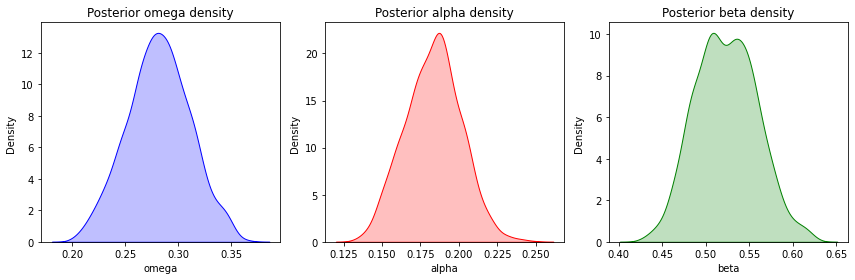

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# plot omega
sns.kdeplot(x1list[(B):(len(x1list))], fill=True, color='b', ax=axes[0])
axes[0].set_xlabel('omega')
axes[0].set_ylabel('Density ')
axes[0].set_title('Posterior omega density')

# plot alpha
sns.kdeplot(x2list[(B):(len(x2list))], fill=True, color='r', ax=axes[1])
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('Density ')
axes[1].set_title('Posterior alpha density')

# plot beta
sns.kdeplot(x3list[(B):(len(x3list))], fill=True, color='g', ax=axes[2])
axes[2].set_xlabel('beta')
axes[2].set_ylabel('Density ')
axes[2].set_title('Posterior beta density')

# space between subgraphs
plt.tight_layout()

# Display
plt.show()

We can now determine the parameters by averaging the sample over the values that do not belong to the burn in :

In [11]:
print("ran Metropolis algorithm for", M, "iterations, with burn-in", B)
print("acceptance rate =", numaccept/i)
u = np.mean(x1list[B:len(x1list)])
print("mean of x1 is about", u)
v = np.mean(x2list[B:len(x2list)])
print("mean of x2 is about", v)
w = np.mean(x3list[B:len(x3list)])
print("mean of x3 is about", w)

ran Metropolis algorithm for 2000 iterations, with burn-in 600
acceptance rate = 0.3707823507601038
mean of x1 is about 0.2814185368750933
mean of x2 is about 0.18310914591500782
mean of x3 is about 0.5231754266211023


We store the 3 samples to use them for the polynomial estimation : 

In [501]:
zvmcmc_results_1step = pd.DataFrame({'omega': x1list, 'alpha': x2list, 'beta': x3list})
zvmcmc_results_1step.to_csv('zvmcmc_results_P1.csv', index=False)

## Control variate estimation

In [585]:
B=4000

In [586]:
v_emp_omega = statistics.variance(mcmc_results['omega'][B:])
v_emp_alpha = statistics.variance(mcmc_results['alpha'][B:])
v_emp_beta = statistics.variance(mcmc_results['beta'][B:])

We transform our 3 lists to be usable in our folowing function :

In [587]:
X_stack = np.vstack([mcmc_results['omega'][B:], mcmc_results['alpha'][B:], mcmc_results['beta'][B:]])

In [588]:
X_stack = X_stack.T

The goal is to regress $g$ on $z$ with $z$ define as the gradient of g with respect to our three parameter. This gradient is thus of dimension 3. We are looking for a vector of coefficient $a$ such that f, our re-normalized function, is equal to:

$$f(x) = g(x) + a^t*z$$

with $a$ equal to the vector of coefficient of an OLS regression of g on z. $f$ is the predicted residuals of the regression of $g$ on $z$. 

This renormalization allows the algorythm to create less variance because the variance of the new function decreases relatively to the first function.

We calculate the density on each combination of simulated parameters of step 1 (we redefine the density function only as a reminder because it is already defined above), it will be our dependant variable in the regresssion:

In [589]:
def g_i(r, h):
    return -0.5 * np.log(h) - 0.5 * (r**2 / h) # Normal law because r_{t}|F_t-1 follow N(0,h_t)

def g(x , data, h_initial): 
    LL = g_i(data[0], h_initial) # g_i(data[0],h_initial) # density is initialized with our first simulated data
    h_t = h_initial
    
    for i in range(1, len(data)):
        h = h_t
        h_t = x[0] + x[1] * data[i-1]**2 + x[2] * h
        LL += g_i(data[i],h_t) #iteration on the Garch process

    return LL

In [590]:
y = list(map(lambda x: g(x, data=r_garch, h_initial=h_initial), X_stack))

We calculate the gradient in the same way. To construct the chain derivatives, we used the chain derivative method. That is, we derived $h(x)$ with respect to $x[i]$, with i ranging from 0 to 2, then $g(h)$ with respect to $h$. Then we just multiply the two derivatives and sum over the whole garch process.

Derivative wrt x[0]:

In [594]:
def z1_i(r, h, x, i):
    return  (1-x[2]**(i))/(1-x[2]) * (-(0.5/h) + (0.5 * r**2)/(h**2))

def z1(x , data, h_initial):
    Z = 0
    h = h_initial 

    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        Z += z1_i(data[i],h,x,i)

    return - x[0]/v_emp_omega + Z

In [595]:
gradient1 = list(map(lambda x: z1(x, data=r_garch, h_initial=h_initial), X_stack))

Derivative wrt x[1]:

In [601]:
def z2_i(r,h,r_lag,h_lag, x, i,h_prime):
    return  (h_prime) * (-(0.5/h) + (0.5 * r**2)/(h**2))

def z2(x , data, h_initial):
    Z = 0
    h_t = h_initial
    h_prime = 0
    
    for i in range(1, len(data)):
        h = h_t
        h_prime = data[i-1]**2 + x[2]*h_prime
        h_t = x[0] + x[1] * data[i-1]**2 + x[2] * h
        Z += z2_i(data[i],h_t,data[i-1],h,x,i,h_prime)

    return - x[1]/v_emp_alpha + Z

In [602]:
gradient2 = list(map(lambda x: z2(x, data=r_garch, h_initial=h_initial), X_stack))

Derivative wrt x[2]:

In [603]:
def z3_i(r,h,r_lag,h_lag, x, i,h_prime):
    return  (h_prime) * (-(0.5/h) + (0.5 * r**2)/(h**2))

def z3(x , data, h_initial):
    Z = 0
    h_t = h_initial
    h_prime = 0
    
    for i in range(1, len(data)):
        h = h_t
        h_prime = h + x[2]*h_prime
        h_t = x[0] + x[1] * data[i-1]**2 + x[2] * h
        Z += z3_i(data[i],h_t,data[i-1],h,x,i,h_prime)

    return - x[2]/v_emp_beta + Z

In [604]:
gradient3 = list(map(lambda x: z3(x, data=r_garch, h_initial=h_initial), X_stack))

We use a simple OLS method robust to heteroscedascticity to estimate $a^t$, i.e the coefficients of the polynomial.

In [605]:
X = np.vstack([gradient1,gradient2,gradient3]).T
#X = sm.add_constant(X) # add a constant
model = sm.OLS(y, X).fit(cov_type='HC3') # regresssion OLS
print(model.summary()) 

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.909
Model:                            OLS   Adj. R-squared (uncentered):              0.909
Method:                 Least Squares   F-statistic:                              4581.
Date:                Sun, 23 Apr 2023   Prob (F-statistic):                        0.00
Time:                        17:34:11   Log-Likelihood:                         -7724.4
No. Observations:                1000   AIC:                                  1.545e+04
Df Residuals:                     997   BIC:                                  1.547e+04
Df Model:                           3                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

Thanks to the estimated coefficients we can define $f$, our new function with a reduced variance :

In [614]:
def f(x , data, h_initial):
    
    f = g(x , data, h_initial) - model.params[0] * z1(x , data, h_initial) - model.params[1] * z2(x , data, h_initial)- model.params[2] * z3(x , data, h_initial)

    return f

## ZV-MCMC

The last step consists in running the algorithm again but with the new function $f$ to calculate the density and accept or not the proposed combination. 

Normally it would be necessary to run a larger number of iteratio than in the first step but the execution time is really expensive for our computers.

We can define the same parameters as in the first step but we have to change the sigma, i.e. the volatility of the normal distribution, which allows us to propose a new combination of parameters, because the variance of the new density function, $f$, has decreased relative to the original $g$ function. We apply a similar procedure to the one applied in Q1 to do it.

In [615]:
M = 2000 # size of the desired sample
#X = np.random.rand(3) # Random starting point for the Markov chain (dim=3)
X= [0.5, 0.5, 0.5] # Deterministic starting point for the Markov chain (dim=3)
sigma = 0.008  # volatility for the proposal function (fixed by looking for an acceptance rate between 0.3 and 0.6)
x1list = []  # for keeping track of omega values
x2list = [] # for keeping track of alpha values
x3list = [] # for keeping track of beta values
numaccept = 0 # counts the number of acceptance in the accept/rejct algorithm
i = 0 #initialization of i, the total number of iteration 
h_initial=optimize_h(r_garch) #initial h for the density computation

Algorythm :

In [616]:
while numaccept < M:
    Y = X + np.random.normal(loc=0, scale=sigma, size=3)  # Proposal move with a normal distribution (dim=3 because 3 parameters)
    U = np.log(np.random.rand(1)) # Random draw in a uniform distribution for accept/reject
    if np.all(Y > 0): # Reject all samples where any parameter is negative (truncated normal distribution)
        alpha = f(Y, data = r_garch, h_initial=h_initial) - f(X, data = r_garch, h_initial=h_initial)  # Difference between current and previous density accept/reject
        if U < alpha:  # Reject if the ratio of densities is lower than a draw in a uniform distribution
            X = Y  # Accept proposal
            numaccept += 1 # Counts the number of acceptance in the accept/reject algorithm
    
            x1list.append(X[0])   # Add the values to the lists of omega
            x2list.append(X[1])   # Add the values to the lists of alpha
            x3list.append(X[2])   # Add the values to the lists of beta
    
    # Output progress report (can be long)
    i += 1 # Counts the number of total iteration 
    if (i % 1000) == 0:
        print(" ...", i,"et taux d'acceptation de", numaccept/i)

 ... 1000 et taux d'acceptation de 0.115


KeyboardInterrupt: 

#### Exploitation of the results

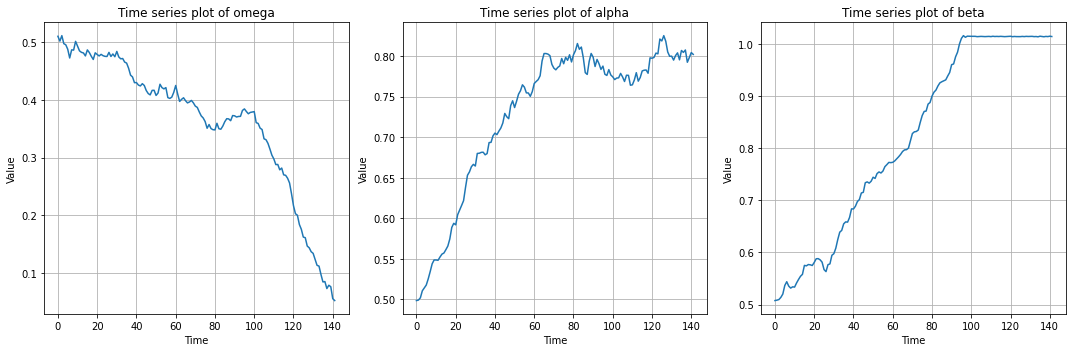

In [617]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot time series graphs for x1list, x2list and x3list
axs[0].plot(x1list)
axs[0].set_title("Time series plot of omega")
axs[1].plot(x2list)
axs[1].set_title("Time series plot of alpha")
axs[2].plot(x3list)
axs[2].set_title("Time series plot of beta")

# Title and grid settings for time series charts
for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)

# Display time series graphs side by side
plt.tight_layout()
plt.show()

In [439]:
B = 100  # amount of burn-in

We plot the density of the sample for each parameters :

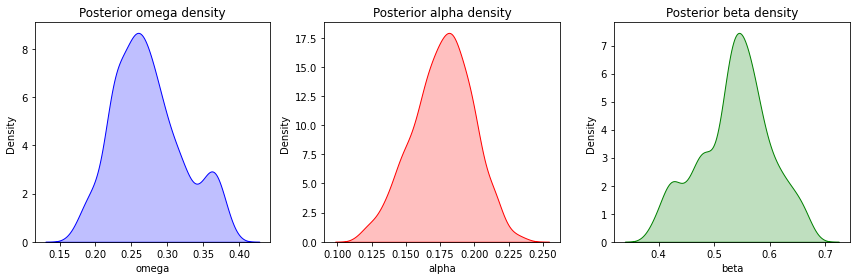

In [440]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# plot omega
sns.kdeplot(x1list[(B):(len(x1list))], fill=True, color='b', ax=axes[0])
axes[0].set_xlabel('omega')
axes[0].set_ylabel('Density ')
axes[0].set_title('Posterior omega density')

# plot alpha
sns.kdeplot(x2list[(B):(len(x2list))], fill=True, color='r', ax=axes[1])
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('Density ')
axes[1].set_title('Posterior alpha density')

# plot beta
sns.kdeplot(x3list[(B):(len(x3list))], fill=True, color='g', ax=axes[2])
axes[2].set_xlabel('beta')
axes[2].set_ylabel('Density ')
axes[2].set_title('Posterior beta density')

# space between subgraphs
plt.tight_layout()

# Display
plt.show()

We can now determine the parameters by averaging the sample over the values that do not belong to the burn in :

In [441]:
print("ran Metropolis algorithm for", M, "iterations, with burn-in", B)
print("acceptance rate =", numaccept/i)
u = np.mean(x1list[B:len(x1list)])
print("mean of x1 is about", u)
v = np.mean(x2list[B:len(x2list)])
print("mean of x2 is about", v)
w = np.mean(x3list[B:len(x3list)])
print("mean of x3 is about", w)

ran Metropolis algorithm for 2000 iterations, with burn-in 100
acceptance rate = 0.4978239035821895
mean of x1 is about 0.2730630534463177
mean of x2 is about 0.176691126646255
mean of x3 is about 0.536824516713166


We calculate the standard error and the true standard error to determine the confidence intervals of our estimators:

In [356]:
def varfact(x): # function to get a variance factor used to obtain true standard error (because of the serial correlationn)
    acf_vals = acf(x, nlags=None, fft=True)  # acf comutation
    var_factor = 2 * np.sum(acf_vals) - 1  # variance factor computation
    return var_factor

In [357]:
# Computation the standard deviations of the x1list, x2list and x3list
se11 = np.std(x1list[(B):(len(x1list))]) / np.sqrt(len(x1list)-B)
se12 = np.std(x2list[(B):(len(x2list))]) / np.sqrt(len(x2list)-B)
se13 = np.std(x3list[(B):(len(x3list))]) / np.sqrt(len(x3list)-B)

# Compute the variance factor of the x1list, x2list and x3list
thevarfact1 = varfact(x1list[(B):(len(x1list))])
thevarfact2 = varfact(x2list[(B):(len(x2list))])
thevarfact3 = varfact(x3list[(B):(len(x3list))])

# Compute the true standard errors of the x1list, x2list and x3list
se1 = se11 * np.sqrt(thevarfact1)
se2 = se12 * np.sqrt(thevarfact2)
se3 = se13 * np.sqrt(thevarfact3)

# Display and compute the 95% confidencce interval
print("true standard error of omega is about", se1)
print("approximate 95% confidence interval of omega is (", u - 1.96 * se1, ",", u + 1.96 * se1, ")\n")

print("true standard error of alpha is about", se2)
print("approximate 95% confidence interval of alpha is (", v - 1.96 * se2, ",", v + 1.96 * se2, ")\n")

print("true standard error of beta is about", se3)
print("approximate 95% confidence interval of beta is (", w - 1.96 * se3, ",", w + 1.96 * se3, ")\n")

true standard error of omega is about 0.007200092993886942
approximate 95% confidence interval of omega is ( 0.3087325861068064 , 0.3369569506428432 )

true standard error of alpha is about 0.003577905889178654
approximate 95% confidence interval of alpha is ( 0.18529040346748268 , 0.199315794553063 )

true standard error of beta is about 0.009719720253056723
approximate 95% confidence interval of beta is ( 0.4521765582837061 , 0.4902778616756885 )



We store the 3 samples to compare with Q1 in the following box plot : 

In [442]:
zvmcmc_results_P1 = pd.DataFrame({'omega': x1list, 'alpha': x2list, 'beta': x3list})
zvmcmc_results_P1.to_csv('zvmcmc_results_P1.csv', index=False)

### Comparaison avec Q1

In [352]:
mcmc_results = pd.read_csv("mcmc_results.csv")

We can see a quasi identic mean (it wouldd be better with more iteration) but a lttle bit less variance with the zero variance method:

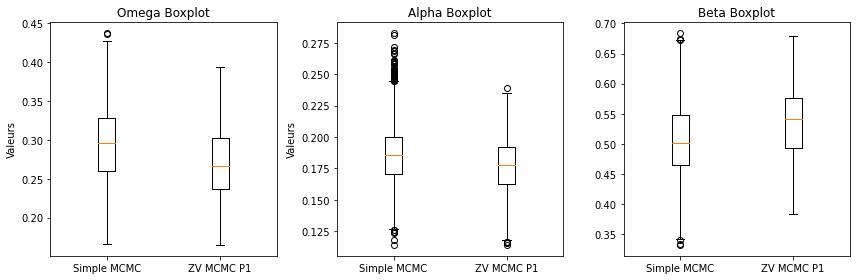

In [443]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Omega box-plot
axes[0].boxplot([mcmc_results['omega'][B:], zvmcmc_results_P1['omega'][B:]])
axes[0].set_xticklabels(['Simple MCMC', 'ZV MCMC P1'])
axes[0].set_ylabel('Valeurs')
axes[0].set_title('Omega Boxplot')

# Alpha box-plot
axes[1].boxplot([mcmc_results['alpha'][B:], zvmcmc_results_P1['alpha'][B:]])
axes[1].set_xticklabels(['Simple MCMC', 'ZV MCMC P1'])
axes[1].set_ylabel('Valeurs')
axes[1].set_title('Alpha Boxplot')

# Beta box-plot
axes[2].boxplot([mcmc_results['beta'][B:], zvmcmc_results_P1['beta'][B:]])
axes[2].set_xticklabels(['Simple MCMC', 'ZV MCMC P1'])
axes[2].set_title('Beta Boxplot')

# space between subplots
fig.tight_layout()

# Display
plt.show()